# Forecasting with ARMA processes

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/06-ARIMA-Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Let's start with a an example by looking at a random walk process (AR(1) with $\phi_1 = 1$).

$$
x_t = x_{t-1} + e_t, \quad e_t \sim \text{i.i.d. } N(0, \sigma^2)
$$

This process can also be expressed as a sum of the past shocks by repeatedly substituting for $x_{t-1}$

$$
\begin{align*}
x_t = (x_{t-2} + e_{t-1}) + e_t = x_{t-2} + e_t + e_{t-1} \\
    = & ((x_{t-3} + e_{t-2}) + e_{t-1}) + e_t = x_{t-3} + e_t + e_{t-1} + e_{t-2} \\
    & \vdots \\
    = & x_0 + e_t + e_{t-1} + e_{t-2} + \ldots + e_1
\end{align*}
$$

The last expression allows us to see that the current value of the series is the sum of all past shocks plus the initial value $x_0$.

$$
x_t = \sum_{j=0}^{t-1} e_{t-j} = x_0 + e_t + e_{t-1} + e_{t-2} + \ldots + e_1
$$

If your bank does not pay interest on your account $\phi_1 = 1$, then this equation simply says that the
the money that you have in your account today (time $t$) is equal to the money you had initially ($x_0$) 
plus all the deposits (shocks $e_t > 0$) minus all the withdrawals (shocks $e_t < 0$) that you have made up to today.

Let's say today you have a balance of 1000 USD in your account ($x_t = 1000$).
Put yourself in the shoes of a bank manager trying to figure out how much money you will keep in his bank tomorrow.
He knows your last balance (1000 USD) and that the balance changed unpredictably from day to day in the past (zero autocorrelations).
He also knows that the day-to-day changes in your balance (the shocks $e_t$) were zero on average (zero expected value) and that they
varied with a standard deviation of, say 10 USD ($\sigma = 10$).


In [ ]:
import numpy as np

# Let's sample some data first (100 values at random from a normal distribution with zero mean and standard deviation of 10)
e = np.random.normal(0, 10, 100)

# Then we take the cumulative sum (according to the formula above) and add 1000 to set the initial balance
x_past = 1000 + np.cumsum(e)

# Finally, we compute the next value in the series by adding a new random shock (withdrawal) to the last known balance
x_next = x_past[-1] + np.random.normal(0, 10)


print("The first 10 values of x are:\n",x_past[:10])

The first 10 values of x are:
 [1006.54704184 1002.91016098 1001.8759707   993.24801277  993.74605449
  981.16242152  983.2575918   990.60551066  999.07166137  996.33109251]


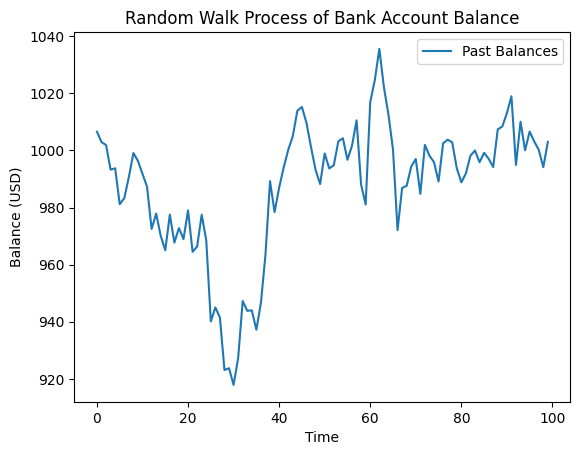

In [4]:
# Plot the random walk process

import matplotlib.pyplot as plt

plt.plot(x_past, label='Past Balances')
plt.title('Random Walk Process of Bank Account Balance')
plt.xlabel('Time')
plt.ylabel('Balance (USD)')
plt.legend()
plt.show()

Now let's try to predict your balance tomorrow ($x_{t+1}$) based on this information. In our code example this boils down to predicting `x_next` based on `x_past`.

We can try two approaches:

- We can take the historical average of your balance as our prediction for tomorrow.
- We can take the last observed balance as our prediction for tomorrow.
- We can simply predict by guessing wildly, meaning that we pick some number and hope for the best.

How can we compare these approaches? Let's assume that for a wrong prediction we will be charged a penalty proportional to the square of the difference between the predicted and the actual balance (squared error loss).

$$
\text{Penalty} = (x_{t+1} - \hat{x}_{t+1})^2
$$

where $\hat{x}_{t+1}$ is our prediction for tomorrow's balance. Now let's compare the three approaches.

In [8]:
print(f"Historical average balance: {np.mean(x_past).round(2)}")
print(f"Last known balance: {x_past[-1].round(2)}")
print(f"Arbitrary forecast: {1050}")


Historical average balance: 1094.32
Last known balance: 1123.54
Arbitrary forecast: 1050


In [ ]:
# Now we run 10 simulations to compare the three forecasting approaches
# In each simulation
# - we generate a new random walk series with 100 past values
# - we compute the next value by sampling a new random shock (net deposit)
#   and adding it to the last known balance
# - we compute the forecasts using the three approaches
# - we compute the square loss for each approach
# - finally, we store the losses for each approach to compare them later

historical_average_losses = []
last_balance_losses = []
arbitrary_forecast_losses = []

for i in range(10):
    x_past = 1000 + np.cumsum(np.random.normal(0, 10, 100))
    x_next = x_past[-1] + np.random.normal(0, 10)

    historical_average = np.mean(x_past)
    last_balance = x_past[-1]
    arbitrary_forecast = 1050

    # Compute the square losses for each forecast
    loss_historical_average = (x_next - historical_average) ** 2
    loss_last_balance = (x_next - last_balance) ** 2
    loss_arbitrary_forecast = (x_next - arbitrary_forecast) ** 2
    
    # Store the losses for later comparison
    historical_average_losses.append(loss_historical_average)
    last_balance_losses.append(loss_last_balance)
    arbitrary_forecast_losses.append(loss_arbitrary_forecast)

    if i % 2 == 0:  # Print results for every second simulation
        print(f"Simulation {i+1}:")
        print(f"  Actual next balance: {x_next.round(2)}")
        print(f"  Loss (Historical Average): {loss_historical_average.round(2)}")
        print(f"  Loss (Last Balance): {loss_last_balance.round(2)}")
        print(f"  Loss (Arbitrary Forecast): {loss_arbitrary_forecast.round(2)}")


Simulation 1:
  Actual next balance: 1079.47
  Loss (Historical Average): 17.98
  Loss (Last Balance): 2.15
  Loss (Arbitrary Forecast): 868.36
Simulation 3:
  Actual next balance: 1024.85
  Loss (Historical Average): 462.77
  Loss (Last Balance): 2.1
  Loss (Arbitrary Forecast): 632.44
Simulation 5:
  Actual next balance: 946.37
  Loss (Historical Average): 537.0
  Loss (Last Balance): 29.05
  Loss (Arbitrary Forecast): 10738.53
Simulation 7:
  Actual next balance: 1110.02
  Loss (Historical Average): 236.61
  Loss (Last Balance): 273.13
  Loss (Arbitrary Forecast): 3602.87
Simulation 9:
  Actual next balance: 1090.95
  Loss (Historical Average): 8605.42
  Loss (Last Balance): 56.42
  Loss (Arbitrary Forecast): 1677.3

Average Losses over all simulations:
  Historical Average: 1650.05
  Last Balance: 164.61
  Arbitrary Forecast: 7314.62


Now let's compare the three approaches. In the loop above we have collected the loss (squared error) for each of the three approaches over multiple simulations. 
Let's compute the average loss for each approach.

In [7]:
# Finally, we compute the average losses for each forecast method
avg_loss_historical_average = np.mean(historical_average_losses)
avg_loss_last_balance = np.mean(last_balance_losses)
avg_loss_arbitrary_forecast = np.mean(arbitrary_forecast_losses)

print("\nAverage Losses over all simulations:")
print(f"  Historical Average: {avg_loss_historical_average.round(2)}")
print(f"  Last Balance: {avg_loss_last_balance.round(2)}")
print(f"  Arbitrary Forecast: {avg_loss_arbitrary_forecast.round(2)}")


Average Losses over all simulations:
  Historical Average: 1650.05
  Last Balance: 164.61
  Arbitrary Forecast: 7314.62


Of the three strategies, the last observed balance is the one where we pay the lowest average penalty.

This is not a coincidence. In fact, the optimal forecast (the one that minimizes the expected squared error loss) for a random walk process is always the last observed value. 
More generally, this is the conditional expectation of the next value given the history of the series (the past values).

$$
E_t (x_{t+1}) = x_t
$$

When taking conditional expectations, we use the notation $E_t(\cdot)$ to indicate that we are conditioning on the information available up to time $t$ (the history of the series).
Under the condition that we known the past values, these are no longer random variables, but fixed numbers. The only uncertainty is about the next shock $e_{t+1}$, which has an expected value of zero.

$$
E_t (x_{t+1}) = E_t (x_t + e_{t+1}) = x_t + E_t(e_{t+1}) = x_t + 0 = x_t
$$

Note that this is quite different from the unconditional expectation, which is the average value of the series without conditioning on the past values.

$$
E (x_{t+1}) = E (x_t + e_{t+1}) = E(x_0 + e_t + e_{t - 1} + \cdots + e_{1}) = x_0
$$

assuming that $x_0$ is fixed.


## The Wold Decomposition and Forecast Errors

Let $x_t$ follow a stationary ARMA process. The Wold decomposition states that every stationary ARMA process can be represented as MA($\infty$).

$$
\begin{align}
x_t = \mu + \sum_{j = 0}^{\infty} \psi_j e_{t - j}, \quad e_t \sim N(0, \sigma^2)
\end{align}
$$

with the restriction that $\psi_0 = 1$ and that the square sum of the coefficients is finite:

$$
\sum_{j = 0}^{\infty} \psi_j^2 \le \infty.
$$


The latter condition ensures that the process has a finite variance. This representation is of limited practical
use, because it contains an _infinite_ number of parameters (which cannot be estimated with finite data). However,
it helps to develop the theoretical properties of all ARMA processes. For example, the variance is really easy
to calculate, because the lags of the white noise process are uncorrelated by assumption:

$$
\begin{align}
Var(x_t) & = Var(\mu) + Var\left(\sum_{j = 0}^{\infty} \psi_j e_{t - j}\right) \\
& = 0 + \sum_{j = 0}^{\infty} Var(\psi_j e_{t - j}) \\
& = \sum_{j = 0}^{\infty} \psi_j^2 Var(e_{t - j}) \\
& = \sum_{j = 0}^{\infty} \psi_j^2 \sigma^2 \\
& = \sigma^2 \sum_{j = 0}^{\infty} \psi_j^2 \\
\end{align}
$$

Let

$$
\hat{y}_t(h) = \mu + \sum_{k = 0}^{\infty} \theta_k^{h} e_{t - k}
$$

be a function that predicts the value of a time series $h$ periods given the history of the series up to time $t$. The error between the value of the process and the prediction for a $h$-steps forecast is the difference between the value of the process $x_{t + h}$ and the forecast:

$$
x_{t + h} - \hat{y}_{t}(h)
$$

it can be shown, that the forecast function with the smallest expected squared error is the conditional expectation of $x_{t + h}$ given the information up to time $t$.

To obtain an expression for the forecast error process, consider the conditional mean of the
white noise process. We write $E_t$ to denote the conditional mean given the information up to and including time $t$.

$$
\begin{align}
E_t(e_{t + h}) =
\begin{cases}
e_{t + h} & h \leq 0 \\
0 & h > 0
\end{cases}
\end{align}
$$


The Wold representation of $x_{t + h}$ is

$$
x_{t + h} = \mu + \psi_0 e_{t + h} + \psi_1 e_{t + h - 1} + \ldots + \psi_h e_t + \psi_{h + 1} e_{t - 1} + \psi_{h + 1} e_{t - 1} + \ldots
$$

The conditional mean is:

$$
E_t(x_{t + h}) = \mu + E_t(\psi_0 e_{t + h}) + E_t(\psi_1 e_{t + h - 1}) + E_t(\ldots) + E_t(\psi_h e_t) + E_t(\psi_{h + 1} e_{t - 1}) + E_t(\psi_{h + 1} e_{t - 1}) + E_t(\ldots)\\
E_t(x_{t + h}) = \mu + \psi_h e_t + \psi_{h + 1} e_{t - 1} + \psi_{h + 1} e_{t - 1} + \ldots
$$

Therefore, the forecast error for the h-steps forecast is:

$$
\begin{align}
f_t(h) = x_{t + h} - E_t(x_{t + h}) = \psi_0 e_{t + h} + \psi_1 e_{t + h - 1} + \psi_2 e_{t + h - 2} +  \ldots
\end{align}
$$

In order to compute prediction intervals, we need the variance of the forecast errors.
This is especially easy for the 1-step ahead forecast:

$$
f_t(1) = e_{t + 1}
$$

and its variance is simply the variance of $e_{t + 1}$ that we have set to $\sigma^2$ by assumption.

$$
Var(f_t(1)) = Var(e_{t + 1}) = \sigma^2
$$

For a two-steps ahead forecast we get:

$$
f_{t}(2) = e_{t + 2} + \psi_1 e_{t + 1}
$$

As the white noise process $e_t$ is uncorrelated (zero covariances), the variance of the forecast errors is simply the sum of the variances of the terms in the sum:

$$
Var(f_{t}(2)) = Var(e_{t + 2}) + Var(\psi_1 e_{t + 1})\\
Var(f_{t}(2)) = \sigma^2 + \psi_1^2 \sigma^2\\
Var(f_{t}(2)) = (1 + \psi_1^2) \sigma^2
$$

For the 3-steps ahead forecast:

$$
f_{t}(3) = e_{t + 3} + \psi_1 e_{t + 2} + \psi_2 e_{t + 1}\\
Var(f_{t}(3)) = (1 + \psi_1^2 + \psi_2^2)\sigma^2
$$

Continuing this, we can find the variance of the h-steps ahead forecast:

$$
Var(f_t(h)) = (1 + \psi_1^2 + \psi_2^2 + \ldots \psi_{h - 1}^2)\sigma^2
$$

To construct approximate 95% prediction intervals for time $t + h$ given the history of the process up to and including $t$:

$$
\hat{y}_t(h) \pm 1.96 \sqrt{Var(f_t(h))}
$$

The $1.96$ factor is the $0.975$ quantile of the standard normal distribution. We must view these prediction intervals with caution, as these are based on the assumption that the forecast errors are approximately normally distributed, uncorrelated and with a constant variance over time. This prediction interval does not account for the uncertainty of estimation that is inherent in the fitting of any model, including the ARIMA models that we study here.


### Forecasting with AR(1)

For a (stationary: $|\phi_1| < 1$) AR(1) process:

$$
x_t = \phi_0 + \phi_1 x_{t - 1} + e_t, e_t \sim WN(\sigma^2)
$$

The optimal forecast is the conditional mean of $x_{t + h}$ given the information (history of the process) up to and including $t$. We write $E_t$ to denote this conditional expectation. For a white noise process $e_t$ the conditional expectation for $t + h$ is:

$$
E_t(e_{t + h}) = \begin{cases}
e_{t + h} & h \leq 0 \\
0 & h > 0
\end{cases}
$$

the conditional mean at time $t + h$ is:

$$
\begin{align}
E_t(x_{t + h}) & = E_t(\phi_0 + \phi_1 y_{t + h - 1} + e_{t + h}) \\
E_t(x_{t + h}) & = \phi_0 + E_t(\phi_1 y_{t + h - 1}) \\
E_t(x_{t + h}) & = \phi_0 + \phi_1 \hat{y}_{t}(h - 1)
\end{align}
$$

Finally, we obtain:

$$
\hat{y}_t(h) = \phi_0 + \phi_1 \hat{y}_{t}(h - 1)
$$

We can solve this by substituting recursively:

For $h = 1$:

$$
\hat{y}_{t}(1) = \phi_0 + \phi_1 \hat{y}_t(0) = \phi_0 + \phi_1 x_t
$$

For $h = 2$:

$$
\begin{align*}
\hat{y}_{t}(2)  & = \phi_0 + \phi_1 \hat{y}_t(1) \\
& = \phi_0 + \phi_1 (\phi_0 + \phi_1 \hat{y}_t(0)) \\
& = \phi_0 + \phi_1 \phi_0 + \phi_1 ^2 \hat{y}_t(0) \\
& = \phi_0 (1 + \phi_1) + \phi_1^2 x_t
\end{align*}
$$

Continuing with the substitution leads to:

$$
\begin{align*}
\hat{y}_t(h)    & = \phi_0 (1 + \phi_1 + \phi_1^2 + \ldots + \phi_1^{h - 1}) + \phi_1^h x_t \\
& = \frac{1 - \phi_1^h}{1 - \phi_1}\phi_0 + \phi_1^h x_{t}
\end{align*}
$$

To derive the variance of the forecast error it is convenient to use the MA($\infty$) representation
of the AR(1) process (Wold representation).

$$
\begin{align}
x_t & = \phi_0 + \phi_1 x_{t - 1} + e_t\\
(1 - \phi_1 L) x_t =  \\
x_t & = \frac{\phi_0}{1 - \phi_1 L} + \frac{e_t}{1 - \phi_1 L} \\
x_t & = \frac{\phi_0}{1 - \phi_1} + (1 + \phi_1 L + \phi_1^2 L^2 + \phi_1^3 L^3 + \ldots) e_{t}\\
x_t & = \frac{\phi_0}{1 - \phi_1} + e_t + \phi_1 e_{t - 1} + \phi_1^2 e_{t - 2} + \phi_1^3 e_{t - 3} + \ldots \\
x_t & = \mu + e_t + \phi_1 e_{t - 1} + \phi_1^2 e_{t - 2} + \phi_1^3 e_{t - 3} + \ldots
\end{align}
$$

We can use this equation to obtain the forecast error for the AR(1) process:

$$
f_t(h) = x_{t + h} - \hat{y}_t(h) = e_{t + h} + \phi_1 e_{t + h - 1} + \phi_1^2 e_{t + h - 1} + \ldots + \phi_1^{h - 1} e_{t + 1}
$$
Now it is easy to calculate the variance of the forecast error:

$$
\begin{align}
Var(f_t(h)) & = \sigma^2 + \phi_1^2 \sigma^2 + \phi_1 ^ 4 \sigma^2 + \ldots + \phi_1^{2(h - 1)}\sigma^2 \\
& = (1 + \phi_1^2 + \phi_1^4 + \ldots \phi_1^{2(h - 1)})\sigma^2\\
& = \frac{1 - \phi_1^{2h}}{1 - \phi_1^2}\sigma^2
\end{align}
$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

ar1 = 2 + arma_generate_sample(ar=[1, -0.75], ma=[1], nsample=100, scale=1)

model_ar1 = ARIMA(ar1, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
print("AR(1) Model Summary:")
print(results_ar1.summary())

AR(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -137.959
Date:                Mon, 10 Nov 2025   AIC                            281.919
Time:                        08:28:48   BIC                            289.734
Sample:                             0   HQIC                           285.082
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5501      0.298      5.204      0.000       0.966       2.134
ar.L1          0.6715      0.085      7.937      0.000       0.506       0.837
sigma2         0.9188      0.16

In [ ]:
forecast = results_ar1.forecast(steps=3)
print("3-step Forecast:")
print(forecast)

3-step Forecast:
[2.31499836 2.06372755 1.89499706]


In [ ]:
forecast_df = results_ar1.get_forecast(steps=3)
forecast_summary = forecast_df.summary_frame()
print(forecast_summary)

y      mean   mean_se  mean_ci_lower  mean_ci_upper
0  2.314998  0.958535       0.436305       4.193692
1  2.063728  1.154596      -0.199239       4.326694
2  1.894997  1.232847      -0.521338       4.311333


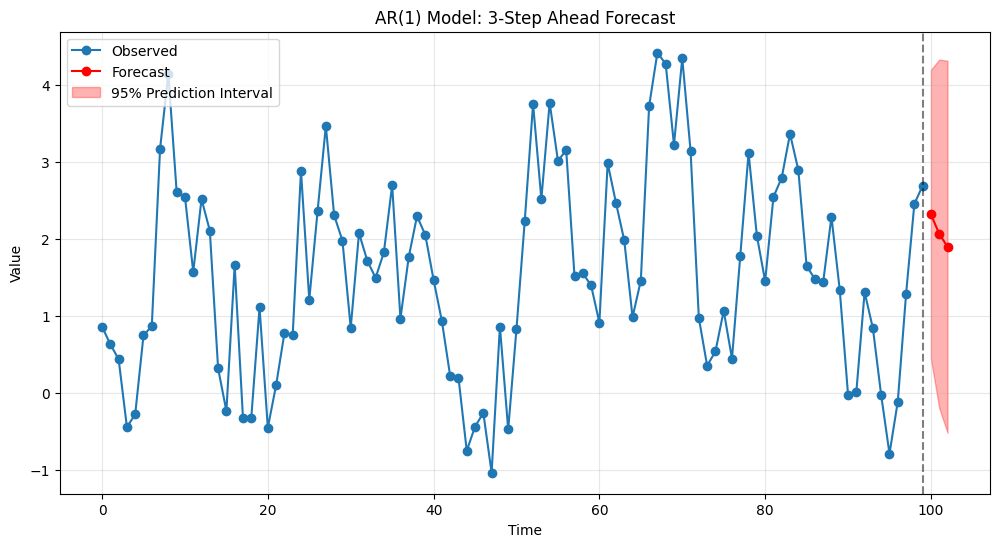

In [ ]:
# Visualize the forecasts
plt.figure(figsize=(12, 6))
plt.plot(ar1, label='Observed', marker='o')
plt.plot(range(len(ar1), len(ar1) + 3), forecast, 
         label='Forecast', marker='o', color='red')

# Add prediction intervals
plt.fill_between(range(len(ar1), len(ar1) + 3),
                 forecast_summary['mean_ci_lower'],
                 forecast_summary['mean_ci_upper'],
                 alpha=0.3, color='red', label='95% Prediction Interval')

plt.axvline(x=len(ar1)-1, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('AR(1) Model: 3-Step Ahead Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Forecasting MA(1)

The moving average process of order one is given by:

$$
x_t = \phi_0 + e_t + \theta_1 e_{t - 1}
$$

The conditional (given the history up to and including $t$) mean of $x_{t + h}$ is:

$$
E_t(x_{t + h}) = \phi_0 + E_t(e_{t + h}) + \theta_1 E_t (e_{t + h - 1})
$$

For a one step ahead prediction ($h = 1$):

$$
\begin{align*}
E_{t}(y_{t + 1}) & = \phi_0 + E_t(e_{t + 1}) + \theta_1 E_t(e_{t}) \\
& = \phi_0 + 0 + \theta_1 e_{t} \\
& = \phi_0 + \theta_1 e_{t}
\end{align*}
$$

Predictions for periods that exceed the order of the MA process (here we have $q = 1$):

$$
E_t(x_{t + h}) = \phi_0
$$

for example for $h = 2$ and MA(1):

$$
\begin{align*}
E_{t}(y_{t + 2}) & = \phi_0 + E_t(e_{t + 2}) + \theta_1 E_t(e_{t + 1}) \\
& = \phi_0 + 0 + \theta_1 \cdot 0 \\
& = \phi_0
\end{align*}
$$

What is problematic here is that in the one-step ahead forecast we need the value of $e_t$, which is not observable so 
we need to estimate it somehow. Let's write $\hat{e}_t$ for our estimate of $e_t$. With this notation
the one-step ahead forecast is:

$$
\hat{y}_t(1) = \phi_0 + \theta_1 \hat{e}_t
$$

Now we need to think of a way to make a reasonable estimate of $e_t$. For that we can look where $e_t$ appears in the MA(1) equation:

$$
x_t = \phi_0 + e_t + \theta_1 e_{t - 1}
$$

If we rearrange this equation we get:

$$
e_t = x_t - \phi_0 - \theta_1 e_{t - 1}
$$

Here we need to realize that the left-hand side is actually the difference 
between the observed value $x_t$ and the one-step ahead forecast made at time $t - 1$:

If we forecast $x_t$ at time $t - 1$ we have:

$$
\begin{align*}
\hat{x}_{t|t - 1} & = E_{t - 1} (x_t) \\
& = E_{t - 1}(e_{t} + \theta_1 e_{t - 1})
& = 0 + \theta_1 e_{t - 1}
\end{align*}
$$

If we can compute this forecast, then we would have

$$
\hat{e}_{t} = x_t - \hat{x}_{t|t - 1}
$$

But to compute this forecast we need to know $e_{t - 1}$ which is also unobservable.

$$
\begin{align*}
\hat{e}_{t - 1} & = x_{t - 1} - \hat{x}_{t - 1|t - 2} \\
\hat{e}_{t - 2} & = x_{t  -2} - \hat{x}_{t - 2|t - 3} \\
\vdots
\end{align*}
$$

Let's see an example

$$
x_t = e_t + 0.5 e_{t - 1}
$$

The data that we have observed is $x_{1} = 1, x_{2} = 0.8, x_{3} = -0.6, x_{4} = 0.2$. Now we want to forecast one period ahead from $t = 4$, in this case $x_{5}$.

The forecast is the conditional expectation:

$$
E_{t = 4}(x_{5}) = 0.5 e_{5 - 1} = 0.5 e_{4}
$$

We don't know the value of $e_{4}$ so we need to estimate it 

$$
\hat{e}_{4} = x_{4} - \hat{x}_{4|3} = x_{4} - 0.5 e_{3}
$$

Here $e_{3}$ is unknown and we estimate it with 

$$
\hat{e}_3 = x_3 - \hat{x}_{3|2} = x_3 - 0.5 e_2
$$

Again we need to go back:

$$
\hat{e}_2 = x_2 - \hat{x}_{2|1} = x_2 - 0.5 e_1
$$

And one last time...

$$
\hat{e}_1 = x_1 - \hat{x}_{1|0} = x_1 - e_0
$$

Now we have another problem because we have run out of data. To estimate $e_0$ we need to observed a value $x_0$, which we don't have.
So at this point we must make an assumption and we have different options. A common assumption is to set $e_0 = 0$ which is its expected value.
Using this assumption we can now compute all the estimates of the shocks:

$$
\begin{align*}
\hat{e}_1 & = x_1 - e_0 = 1 - 0 = 1 \\
\hat{e}_2 & = x_2 - 0.5 \hat{e}_1 = 0.8 - 0.5 \cdot 1 = 0.3 \\
\hat{e}_3 & = x_3 - 0.5 \hat{e}_2 = -0.6 - 0.5 \cdot 0.3 = -0.75 \\
\hat{e}_4 & = x_4 - 0.5 \hat{e}_3 = 0.2 - 0.5 \cdot (-0.75) = 0.575 \\
\end{align*}
$$

Finally we can compute the one-step ahead forecast for $x_5$:

$$
\hat{x}_{5|4} = 0.5 \hat{e}_4 = 0.5 \cdot 0.575 = 0.2875
$$

Let's check our result with the forecast function in `statsmodels`.

In [14]:
# $x_{1} = 1, x_{2} = 0.8, x_{3} = -0.6, x_{4} = 0.2$

from statsmodels.tsa.arima.model import ARIMA

ma_data = np.array([1, 0.8, -0.6, 0.2])

# The model in our example does not have a constant term, so we set trend='n'

ma1_model = ARIMA(ma_data, order=(0, 0, 1), trend='n')

# Usually we would call fit() to estimate the parameters.
# Here we use fit_constrained to set ma.L1 = 0.5 directly because this is the value
# of the theta parameter in our example

ma1_results = ma1_model.fit_constrained({'ma.L1': 0.5})
print(ma1_results.summary())
ma1_results.forecast(steps=1)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    4
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  -4.349
Date:                Tue, 25 Nov 2025   AIC                             10.697
Time:                        15:27:30   BIC                             10.084
Sample:                             0   HQIC                             9.351
                                  - 4                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ma.L1 (fixed)     0.5000        nan        nan        nan         nan         nan
sigma2            0.4794      0.927      0.517      0.605      -1.337       2.295
Ljung-Box (L1) (Q):                   0.

/home/amarov/stats/ts2025/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/amarov/stats/ts2025/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/home/amarov/stats/ts2025/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


array([0.29442815])



## Forecasting ARIMA(1, 0, 1)

Let us combine the methods used for forecasting the AR(1) and the MA(1) models.

$$
x_t = \phi_0 + \phi_1 x_{t - 1} + e_t + \theta_1 e_{t - 1}
$$

The conditional mean of $y_{t + 1}$ given the history of the process up to and including $t$ is:

$$
\hat{y}_t(1) = E_t(y_{t + 1}) = \phi_0 + \phi_1 x_t + E_t(e_{t + 1}) +  \theta_1 e_{t}
$$

The problem here is that $e_t$ is not observable, and therefore we cannot use the equation above directly. Instead, we need to estimate $e_t$ from the forecast errors:

$$
\hat{e}_t = x_t - \hat{y}_{t - 1}(1)
$$

For $t = 0$ the forecast is:

$$
\hat{y}_{0}(1) = \phi_0 + \phi_1 y_0 + \theta_1 e_0\\
$$

For $t = 1$:

$$
\begin{align}
\hat{y}_{1}(1)  & = \phi_0 + \phi_1 y_1 + \theta_1 e_1 \\
& = \phi_0 + \phi_1 y_1 + \theta_1 (y_1 - \hat{y}_{0}(1)) \\
& = \phi_0 + \phi_1 y_1 + \theta_1 (y_1 - (\phi_0 + \phi_1 y_0 + \theta_1 e_0)) \\
& = \phi_0 (1 - \theta_1) + (\phi_1 + \theta_1)y_1 - \theta_1 \phi_1 y_0 + \theta_1^2e_0
\end{align}
$$

We can continue substituting until we finally get an (admittedly) long expression for the forecast at time $t$.

$$
\begin{align}
\hat{y}_{t}(1) = & \phi_0(1 -\theta_1 - \theta_1^2 - \theta_1^t) +\\ 
& (\phi_1 - \theta_1) x_t - \theta_1(\phi_1 + \theta_1)) x_{t - 1} +\\
& \ldots +\\
& \theta_1^{t - 1}(\phi_1 + \theta_1) y_1 + \theta_1^t \phi_1 y_0 + \theta_1^{t + 1} e_0
\end{align}
$$

To calculate the predictions for more than one period, you can use the recursive relationship:

$$
\begin{align}
\hat{y}_t(2) = & \phi_0 + \phi_1 \hat{y}_t(1)\\
\hat{y}_t(3) = & \phi_0 + \phi_1 \hat{y}_t(2)\\
& \vdots\\
\end{align}
$$

## Forecasting ARIMA processes

If the process is ARIMA with $d = 1$, then we need to de-difference the forecast:

$$
\hat{y}_t(h) = x_t + \Delta \hat{y}_{t}(1) + \Delta \hat{y}_{t}(2) + \ldots + \Delta \hat{y}_{t}(h)
$$

If the process is ARIMA with $d = 2$:

$$
\hat{y}_t(h) = x_t + \left(\Delta x_t + \phi_0^2 \hat{y}_{t}(1)\right) + \left(\Delta x_t + \Delta^2 \hat{y}_{t}(1) \Delta^2 \hat{y}_t(2)\right) + \ldots + \left(\Delta x_t + \Delta^2 \hat{y}_{t}(1) \Delta^2 \hat{y}_t(2) + \ldots + \Delta^2\hat{y}_t(h)\right)
$$



## Example from the Lecture: ARIMA(1, 1, 1)

$$
\Delta x_t = 0.1 \Delta y_{t−1} + e_t + 0.2 e_{t−1}
$$

Compute the one-step ahead forecast of the model given the values

| t   | y   | $x _t = \Delta x_t$ | $\hat{x}_{t - 1}(1)$                            | $\hat{e}_{t}$            |
|-----|-----|-----------------------|-------------------------------------------------|--------------------------|
| -1  |     |                       |                                                 |                          |
| 0   | -11 | NA                    |                                                 |                          |
| 1   | 2   | 13                    |                                                 | $0$                      |
| 2   | 5   | 3                     | $0.1\cdot(13) + 0.2\cdot 0 = 1.3$               | $3 - 1.3 = 1.7$          |
| 3   | -1  | -6                    | $0.1\cdot(3) + 0.2\cdot 1.7 = 0.64$             | $-6 - 0.64 = -6.64$      |
| 4   | 13  | 14                    | $0.1\cdot(-6) + 0.2\cdot (-6.64) = -1.928$      | $14 - (-1.928) = 15.928$ |
| T=5 | 4   | -9                    | $0.1\cdot(14) + 0.2\cdot (15.928) = 4.5856$     | $-9 - 4.5856 = -13.5856$ |
| 6   | ?   |                       | $0.1\cdot(-9) + 0.2\cdot (-13.5856) = -3.61712$ | $0$                      |
| 7   | ?   |                       | $0.1\cdot(-3.61712) + 0.2\cdot 0 = -0.361712$   |                          |

To calculate the forecast, start with the observation at $t = 2$. For the observations before that there are no available values. For the sake of convenience, we will set $\Delta x_t = x_t$. The optimal forecast is given by the conditional mean of the series:

$$
\begin{align}
\hat{x}_{t}(1) & = E_{t}(x_{t + 1}) = E_{t}(0.1 x_t + e_{t + 1} + 0.2 e_{t}) \\
\hat{x}_{t}(1) & = E_{t}(x_{t + 1}) = 0.1 x_t + 0.2 \hat{e}_{t}
\end{align}
$$

Let's calculate the one step ahead forecast for $x_2$:

$$
\hat{x}_{1}(1) = E_{1}(x_{2}) = 0.1 x_1 + 0.2 \hat{e}_{1}
$$

For the next steps we will estimate $e_{t}$ from the forecast error but for the initial values (where we cannot compute the residual) we will set $e_{1} = 0$. There are different ways to choose the initial values, but this is the simplest one and is used in the `predict.Arima` function in R. Note that that the example in the lecture uses another approach.

$$
\hat{x}_{1}(1) = 0.1 \cdot 13 + 0.2 \cdot 0 = 1.3
$$

The forecast for $x_3$ is:

$$
\begin{align}
\hat{x}_{2}(1) & = 0.1 x_{2} + 0.2 \hat{e}_{2}\\
\hat{e}_{2} & = x_2 - \hat{x}_1(1) = 3 - 1.3 = 1.7 \\
\hat{x}_{2}(1) & = 0.1 \cdot 3 + 0.2 1.7 = 0.64 \\
\end{align}
$$

We repeat this calculation until we get to the final step. Note that when forecasting $x_7$ the
forecast equation is:

$$
\hat{x}_{6}(1) = 0.1 \hat{x}_{6} = −0.36
$$

To get the prediction for $y_5$ and $y_6$, use apply the formula for reversing the differencing ($d = 1$):

$$
\hat{y}_t(h) = x_t + \phi_0 \hat{y}_{t}(1) + \phi_0 \hat{y}_{t}(2) + \ldots + \phi_0 \hat{y}_{t}(h)
$$

For the one step ahead prediction we obtain $(h = 1)$:

$$
\begin{align}
\hat{y}_t(1) & = x_t + \hat{x}_t(1) \\
\hat{y}_5(1) & = y_{5} + \hat{x}_5(1) = 4 + (−3.61712) = 0.38288
\end{align}
$$

For the two steps prediction we obtain $(h = 2)$

$$
\begin{align}
\hat{y}_t(2) & = x_t + \hat{x}_t(1) + \hat{x}_t(2) \\
\hat{y}_5(2) & = y_{5} + \hat{x}_5(1) + \hat{x}_5(2) = 4 + (−3.61712) + (−0.361712) = 0.021168
\end{align}
$$

We can verify the prediction using `arima` and `predict`. First, we enter the
values by hand and compute the first difference.

In [ ]:
# \Delta x_t = 0.1 \Delta y_{t−1} + e_t + 0.2 e_{t−1}

y = np.array([-11, 2, 5, -1, 13, 4])

x = np.diff(y)

print("Original Series y:", y)
print("Differenced Series x:", x)

Original Series y: [-11   2   5  -1  13   4]
Differenced Series x: [13  3 -6 14 -9]


In [ ]:
model = ARIMA(y, order=(1, 1, 1), trend='n')

results = model.fit_constrained({'ar.L1': 0.1, 'ma.L1': 0.2})
print(results.summary())
results.forecast(steps=2)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    6
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -19.223
Date:                Mon, 10 Nov 2025   AIC                             40.446
Time:                        09:30:48   BIC                             40.056
Sample:                             0   HQIC                            39.398
                                  - 6                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1 (fixed)     0.1000        nan        nan        nan         nan         nan
ma.L1 (fixed)     0.2000        nan        nan        nan         nan         nan
sigma2          125.6172    151.747     

c:\Users\boyko\stats\ts2025\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\boyko\stats\ts2025\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


array([0.38670036, 0.0253704 ])

In [ ]:
results.resid

array([-11.        ,  13.00042704,  -0.68343784,  -6.16376649,
        15.83258952, -13.56650108])


## Example with ARIMA(2, 1, 1)

$$
\Delta y_t = 0.1 \Delta y_{t−1} + 0.3 \Delta y_{t - 2} + e_t + 0.2 e_{t−1}
$$

Again, set $x_t = \Delta y_t$ to get a regular ARMA(2, 1) model.

$$
x_t = 0.1 x_{t - 1} + 0.3 x_{t - 2} + e_t + 0.2 e_{t−1}
$$

The optimal forecast is (again) the conditional mean of the process:

$$
\hat{x}_{t}(1) = 0.1 x_t + 0.3 x_{t - 1} + 0.2 \hat{e}_{t}
$$

Your first prediction will be for $t = 3$, because you have no values for $x$ before $t = 1$.

$$
\hat{x}_2(1) = 0.1x_{2} + 0.3 x_{1} + \hat{e}_{2} = 0.1 \cdot 3 + 0.3 \cdot 13 + 0 = 4.2
$$

As you cannot estimate $e_2$ from the residuals, set it to zero. With this estimate, the forecast error is

$$
\hat{e}_{3} = x_3 - \hat{x}_2(1) = -6 - 4.2 = -10.2
$$

You will use this error in the next step to calculate the forecast for $x_4$:

$$
\hat{x}_3(1) = 0.1 x_{3} + 0.3 x_{2} + \hat{e}_3 = 0.1 \cdot (-6) + 0.3 \cdot 3 + 0.2 \cdot (-10.2) = -1.74
$$

You continue this way until you reach the $t = 7$. Then you apply the de-differencing formula as in the previous example.


| t   | y   | $x _t = \Delta x_t$ | $\hat{x}_{t - 1}(1)$ | $\hat{e}_{t}$          |
|-----|-----|-----------------------|----------------------|------------------------|
| -1  |     |                       |                      |                        |
| 0   | -11 | NA                    |                      |                        |
| 1   | 2   | 13                    |                      | $0$                    |
| 2   | 5   | 3                     |                      | $0$                    |
| 3   | -1  | -6                    | 4.2                  | $-6 - 4.2 = -10.2$     |
| 4   | 13  | 14                    | -1.74                | $14 - (-1.74) = 15.74$ |
| T=5 | 4   | -9                    |                      | $-11.748$              |
| 6   | ?   |                       |                      | $0$                    |
| 7   | ?   |                       |                      | $0$                    |


## Example with ARIMA(1, 1, 2)

$$
\Delta x_t = 0.1 \Delta y_{t−1} + e_t + 0.2 e_{t−1} + 0.3 e_{t -2}
$$

Substituting $\Delta x_t = x_t$:

$$
x_t = 0.1 x_{t−1} + e_t + 0.2 e_{t−1} + 0.3 e_{t -2}
$$

The optimal forecast is given by:

$$
\hat{x}_{t}(1) = 0.1 x_{t} + 0.2 \hat{e}_{t} + 0.3 \hat{e}_{t - 1}
$$

The first prediction for $x_2$ is given by:

$$
\hat{x}_1(1) = 0.1 x_{1} + 0.2 \hat{e}_{1} + 0.3 \hat{e}_{0}
$$

Initializing the forecast error series with zeroes we get:

$$
\hat{x}_1(1) = 0.1 \cdot 13 + 0.2 \cdot 0 + 0.3 \cdot 0 = 1.3 \\
\hat{e}_2 = 3 - 1.3 = 1.7
$$

The next forecast error is:

$$
\hat{x}_2(1) = 0.1 x_{2} + 0.2 \hat{e}_2 + 0.3 \hat{e}_1\\
\hat{x}_2(1) = 0.1 \cdot 3 + 0.2 \cdot 1.7 + 0.3 \cdot 0 = 0.64\\
\hat{e}_3 = -6 - 0.64 = -6.64
$$

and then:

$$
\hat{x}_3(1) = 0.1 x_{3} + 0.2 \hat{e}_3 + 0.3 \hat{e}_2\\
\hat{x}_3(1) = 0.1 \cdot (-6) + 0.2 \cdot (-6.64) + 0.3 \cdot 1.7 = -1.418\\
\hat{e}_4 = 14 - (-1.418) = 15.418
$$


```{r}
fit_ARIMA_1_0_2 <- arima(
  x,
  order = c(1, 0, 2),
  fixed = c(0.1, 0.2, 0.3, 0),
  method = "CSS"
)
fit_ARIMA_1_0_2
```

```{r}
residuals(fit_ARIMA_1_0_2)
```


| t   | y   | $x _t = \Delta x_t$ | $\hat{x}_{t - 1}(1)$ | $\hat{e}_{t}$  |
|-----|-----|-----------------------|----------------------|----------------|
| -1  |     |                       |                      |                |
| 0   | -11 | NA                    |                      | $0$            |
| 1   | 2   | 13                    |                      | $0$            |
| 2   | 5   | 3                     | 1.3                  | $1.7$          |
| 3   | -1  | -6                    | 0.64                 | $-6.64$        |
| 4   | 13  | 14                    |                      | $15.418$       |
| T=5 | 4   | -9                    |                      | $-11.4916$     |
| 6   | ?   |                       |                      |                |
| 7   | ?   |   